In [1]:
print("hello world")

hello world


In [2]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms # .v2 as transforms
from torchvision.models import resnet50
from torchvision.ops import sigmoid_focal_loss
from torch.amp import GradScaler

# Local imports
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
# print(parent_dir)
tool_path = os.path.abspath(os.path.normpath(parent_dir))
if tool_path not in sys.path:
    sys.path.insert(0, tool_path)

from tools.data_tools import crop_image_tensor
from tools.model_tools import validate, train_and_test_model
from tools.visualization_tools import plot_training_statistics, print_training_statistics
from classes.RetinaDataset import RetinaDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Data Transformation & Augmentation

In [3]:
mean, std = pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Mean'].values, pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Std'].values

mean = np.array(mean, dtype=np.float32, copy=True)
std = np.array(std, dtype=np.float32, copy=True)

mean_tensor = torch.from_numpy(mean)
std_tensor = torch.from_numpy(std)

print(f"Mean: {mean_tensor}")
print(f"Std: {std_tensor}")

Mean: tensor([0.4493, 0.2722, 0.1405])
Std: tensor([0.2548, 0.1612, 0.0879])


ResNet50 gets 256*256 tensors

In [4]:
# Appliquer les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)), 
    transforms.Normalize(mean=mean, std=std)
])

# Single augmentation transform with random applications
transform_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)),
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=1.0)
    ], p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=15)  # Reduced from 30 to preserve medical image integrity
    ], p=0.3),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ], p=0.3),
    transforms.Normalize(mean=mean, std=std)
])

## 2. Data Loading

In [5]:
train_dataset = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform_augmented,  # Use augmented transform with random applications
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)

test_dataset = RetinaDataset(
    root_dir='../../data/Test-Set/Test',
    csv_file='../../data/Test-Set/Testing_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)

val_dataset = RetinaDataset(
    root_dir='../../data/Evaluation-Set/Validation',
    csv_file='../../data/Evaluation-Set/Validation_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

## 3. ResNet50 definition

In [6]:
NUMBER_OF_LABELS = 4  

model = resnet50(weights="IMAGENET1K_V2") # https://docs.pytorch.org/vision/stable/models.html#convolutional-neural-networks 
model.fc = nn.Linear(model.fc.in_features, NUMBER_OF_LABELS) 
model = model.to(device) 

for param in model.parameters(): # first layers frozen
    param.requires_grad = False
for param in model.fc.parameters(): # last layer trainable
    param.requires_grad = True

## 4. Loss definition

In [7]:
alpha = 0.25  # penalisation of minor classes
gamma = 2.0   # focusing parameter for modulating factor (1-p) to reduce the relative loss for well-classified examples, putting more focus on hard, misclassified examples
criterion = lambda outputs, labels: sigmoid_focal_loss(
    outputs, labels, alpha=alpha, gamma=gamma, reduction='mean'
) # equivalent to nn.BCEWithLogitsLoss() when alpha=1 and gamma=0
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
scaler = GradScaler()  # For Automatic Mixed Precision

## 5. Model training

In [8]:
# Early stopping
patience = 5  
min_delta = 0.001  
best_test_loss = float('inf')
counter = 0

training_statistics = {
    'epoch': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'test_f1s': [],
    'train_f1s': [],
    'train_roc_aucs': [],
    'test_roc_aucs': []
}

num_epochs = 30

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch number: {epoch}")

    # Training and evaluation
    train_loss, train_accuracy, train_f1, train_roc_auc, test_loss, test_accuracy, test_f1, test_roc_auc = train_and_test_model(
        model=model, 
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer, 
        criterion=criterion, 
        device=device,
        num_labels=NUMBER_OF_LABELS,
        scaler=scaler)
    
    # Print metrics
    print_training_statistics(
        train_loss, train_accuracy, train_f1, train_roc_auc, 
        test_loss, test_accuracy, test_f1, test_roc_auc,
        get_device_properties=True, memory_allocated=True, memory_reserved=True
    )
    
    # Early stopping
    scheduler.step(test_loss)  
    if epoch > 15:
        if (best_test_loss - test_loss) > min_delta:
            best_test_loss = test_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping à l'epoch {epoch}")
            break

    # Metrics storage
    training_statistics['epoch'].append(epoch)
    training_statistics['train_losses'].append(train_loss)
    training_statistics['train_accuracies'].append(train_accuracy)
    training_statistics['train_f1s'].append(train_f1)
    training_statistics['train_roc_aucs'].append(train_roc_auc)
    training_statistics['test_losses'].append(test_loss)
    training_statistics['test_accuracies'].append(test_accuracy)
    training_statistics['test_f1s'].append(test_f1)
    training_statistics['test_roc_aucs'].append(test_roc_auc)



Epoch number: 0


100%|██████████| 10/10 [00:39<00:00,  4.00s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0949 | Train Accuracy: 0.6443 | Train F1-score: 0.2359 | Train ROC-AUC: 0.5084 |
| Test Loss:  0.0823 | Test Accuracy:  0.7159 | Test F1-score:  0.0251 | Test ROC-AUC:  0.5264 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 1


100%|██████████| 10/10 [00:49<00:00,  4.91s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0778 | Train Accuracy: 0.7286 | Train F1-score: 0.0100 | Train ROC-AUC: 0.4935 |
| Test Loss:  0.0722 | Test Accuracy:  0.7238 | Test F1-score:  0.0000 | Test ROC-AUC:  0.5080 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 2


100%|██████████| 10/10 [00:42<00:00,  4.20s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0667 | Train Accuracy: 0.7302 | Train F1-score: 0.0000 | Train ROC-AUC: 0.5116 |
| Test Loss:  0.0656 | Test Accuracy:  0.7238 | Test F1-score:  0.0000 | Test ROC-AUC:  0.5119 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 3


100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0624 | Train Accuracy: 0.7302 | Train F1-score: 0.0000 | Train ROC-AUC: 0.5312 |
| Test Loss:  0.0629 | Test Accuracy:  0.7238 | Test F1-score:  0.0000 | Test ROC-AUC:  0.5323 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 4


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0593 | Train Accuracy: 0.7302 | Train F1-score: 0.0000 | Train ROC-AUC: 0.5518 |
| Test Loss:  0.0609 | Test Accuracy:  0.7238 | Test F1-score:  0.0000 | Test ROC-AUC:  0.5636 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 5


100%|██████████| 10/10 [00:35<00:00,  3.52s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0573 | Train Accuracy: 0.7302 | Train F1-score: 0.0000 | Train ROC-AUC: 0.5865 |
| Test Loss:  0.0591 | Test Accuracy:  0.7238 | Test F1-score:  0.0000 | Test ROC-AUC:  0.6013 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 6


100%|██████████| 10/10 [00:38<00:00,  3.86s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0564 | Train Accuracy: 0.7302 | Train F1-score: 0.0000 | Train ROC-AUC: 0.6173 |
| Test Loss:  0.0578 | Test Accuracy:  0.7238 | Test F1-score:  0.0000 | Test ROC-AUC:  0.6403 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 7


100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0555 | Train Accuracy: 0.7302 | Train F1-score: 0.0000 | Train ROC-AUC: 0.6368 |
| Test Loss:  0.0569 | Test Accuracy:  0.7238 | Test F1-score:  0.0000 | Test ROC-AUC:  0.6750 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 8


100%|██████████| 10/10 [00:40<00:00,  4.04s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0541 | Train Accuracy: 0.7302 | Train F1-score: 0.0000 | Train ROC-AUC: 0.6776 |
| Test Loss:  0.0557 | Test Accuracy:  0.7238 | Test F1-score:  0.0000 | Test ROC-AUC:  0.7028 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 9


100%|██████████| 10/10 [00:38<00:00,  3.88s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0530 | Train Accuracy: 0.7302 | Train F1-score: 0.0000 | Train ROC-AUC: 0.7099 |
| Test Loss:  0.0547 | Test Accuracy:  0.7238 | Test F1-score:  0.0000 | Test ROC-AUC:  0.7298 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 10


100%|██████████| 10/10 [00:38<00:00,  3.86s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0526 | Train Accuracy: 0.7302 | Train F1-score: 0.0000 | Train ROC-AUC: 0.7193 |
| Test Loss:  0.0537 | Test Accuracy:  0.7238 | Test F1-score:  0.0000 | Test ROC-AUC:  0.7521 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 11


100%|██████████| 10/10 [00:39<00:00,  3.94s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0517 | Train Accuracy: 0.7304 | Train F1-score: 0.0015 | Train ROC-AUC: 0.7433 |
| Test Loss:  0.0529 | Test Accuracy:  0.7238 | Test F1-score:  0.0000 | Test ROC-AUC:  0.7705 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 12


100%|██████████| 10/10 [00:38<00:00,  3.80s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0507 | Train Accuracy: 0.7304 | Train F1-score: 0.0015 | Train ROC-AUC: 0.7616 |
| Test Loss:  0.0519 | Test Accuracy:  0.7238 | Test F1-score:  0.0000 | Test ROC-AUC:  0.7859 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 13


100%|██████████| 10/10 [00:39<00:00,  3.94s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0501 | Train Accuracy: 0.7306 | Train F1-score: 0.0029 | Train ROC-AUC: 0.7709 |
| Test Loss:  0.0511 | Test Accuracy:  0.7238 | Test F1-score:  0.0000 | Test ROC-AUC:  0.7973 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 14


100%|██████████| 10/10 [00:43<00:00,  4.30s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0502 | Train Accuracy: 0.7308 | Train F1-score: 0.0044 | Train ROC-AUC: 0.7652 |
| Test Loss:  0.0510 | Test Accuracy:  0.7250 | Test F1-score:  0.0088 | Test ROC-AUC:  0.8103 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 15


100%|██████████| 10/10 [00:34<00:00,  3.45s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0486 | Train Accuracy: 0.7314 | Train F1-score: 0.0087 | Train ROC-AUC: 0.7950 |
| Test Loss:  0.0497 | Test Accuracy:  0.7262 | Test F1-score:  0.0175 | Test ROC-AUC:  0.8172 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 16


100%|██████████| 10/10 [00:37<00:00,  3.72s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0481 | Train Accuracy: 0.7325 | Train F1-score: 0.0173 | Train ROC-AUC: 0.8020 |
| Test Loss:  0.0489 | Test Accuracy:  0.7268 | Test F1-score:  0.0218 | Test ROC-AUC:  0.8243 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 17


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0478 | Train Accuracy: 0.7339 | Train F1-score: 0.0272 | Train ROC-AUC: 0.8084 |
| Test Loss:  0.0484 | Test Accuracy:  0.7287 | Test F1-score:  0.0347 | Test ROC-AUC:  0.8317 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 18


100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0471 | Train Accuracy: 0.7353 | Train F1-score: 0.0371 | Train ROC-AUC: 0.8141 |
| Test Loss:  0.0477 | Test Accuracy:  0.7329 | Test F1-score:  0.0641 | Test ROC-AUC:  0.8350 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 19


100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0462 | Train Accuracy: 0.7367 | Train F1-score: 0.0468 | Train ROC-AUC: 0.8285 |
| Test Loss:  0.0471 | Test Accuracy:  0.7378 | Test F1-score:  0.0966 | Test ROC-AUC:  0.8414 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 20


100%|██████████| 10/10 [00:35<00:00,  3.52s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0468 | Train Accuracy: 0.7416 | Train F1-score: 0.0809 | Train ROC-AUC: 0.8198 |
| Test Loss:  0.0474 | Test Accuracy:  0.7396 | Test F1-score:  0.1086 | Test ROC-AUC:  0.8500 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 21


100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0453 | Train Accuracy: 0.7394 | Train F1-score: 0.0674 | Train ROC-AUC: 0.8303 |
| Test Loss:  0.0461 | Test Accuracy:  0.7445 | Test F1-score:  0.1396 | Test ROC-AUC:  0.8520 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 22


100%|██████████| 10/10 [00:36<00:00,  3.66s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0462 | Train Accuracy: 0.7420 | Train F1-score: 0.0848 | Train ROC-AUC: 0.8240 |
| Test Loss:  0.0464 | Test Accuracy:  0.7470 | Test F1-score:  0.1582 | Test ROC-AUC:  0.8583 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 23


100%|██████████| 10/10 [00:36<00:00,  3.61s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0446 | Train Accuracy: 0.7449 | Train F1-score: 0.1046 | Train ROC-AUC: 0.8412 |
| Test Loss:  0.0452 | Test Accuracy:  0.7463 | Test F1-score:  0.1545 | Test ROC-AUC:  0.8597 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 24


100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0443 | Train Accuracy: 0.7478 | Train F1-score: 0.1240 | Train ROC-AUC: 0.8433 |
| Test Loss:  0.0449 | Test Accuracy:  0.7512 | Test F1-score:  0.1840 | Test ROC-AUC:  0.8635 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 25


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0431 | Train Accuracy: 0.7488 | Train F1-score: 0.1303 | Train ROC-AUC: 0.8568 |
| Test Loss:  0.0442 | Test Accuracy:  0.7555 | Test F1-score:  0.2091 | Test ROC-AUC:  0.8666 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 26


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0430 | Train Accuracy: 0.7533 | Train F1-score: 0.1591 | Train ROC-AUC: 0.8573 |
| Test Loss:  0.0437 | Test Accuracy:  0.7579 | Test F1-score:  0.2231 | Test ROC-AUC:  0.8691 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 27


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0426 | Train Accuracy: 0.7555 | Train F1-score: 0.1747 | Train ROC-AUC: 0.8606 |
| Test Loss:  0.0433 | Test Accuracy:  0.7591 | Test F1-score:  0.2330 | Test ROC-AUC:  0.8729 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.11 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 28


100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0426 | Train Accuracy: 0.7553 | Train F1-score: 0.1757 | Train ROC-AUC: 0.8577 |
| Test Loss:  0.0428 | Test Accuracy:  0.7616 | Test F1-score:  0.2466 | Test ROC-AUC:  0.8768 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.11 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 29


100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0425 | Train Accuracy: 0.7624 | Train F1-score: 0.2160 | Train ROC-AUC: 0.8574 |
| Test Loss:  0.0423 | Test Accuracy:  0.7640 | Test F1-score:  0.2600 | Test ROC-AUC:  0.8800 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.10 Go          | cached: 3.18 Go       |
------------------------------------------------------------------------------------------------


In [10]:
torch.save(model.state_dict(), '../Models/model_ft_resnet50_mcmlc.pth')

In [11]:
training_statistics_df = pd.DataFrame(training_statistics)
training_statistics_df.to_csv('../Training-Statistics/ts_model_ft_resnet50_mcmlc.csv', index=False)

## 6. Evolution of the training

In [12]:
training_statistics_df = pd.read_csv('../Training-Statistics/ts_model_ft_resnet50_mcmlc.csv')

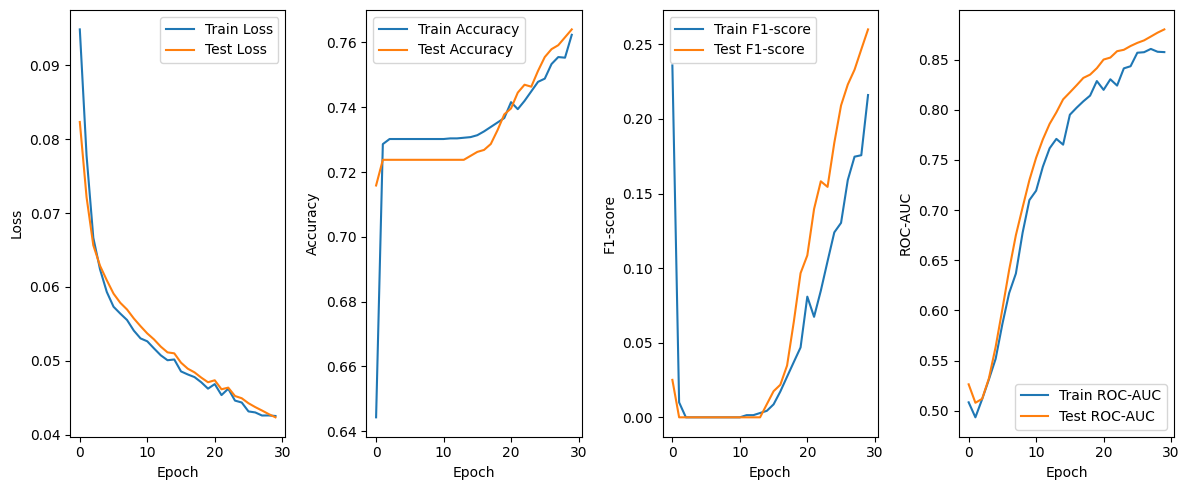

In [13]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_model_ft_resnet50_mcmlc_zoomed.png',
    title='Training Evolution - Fine Tuned ResNet50 Multi-Class Multi-Labeling Zoomed',
    zoomed=True
)


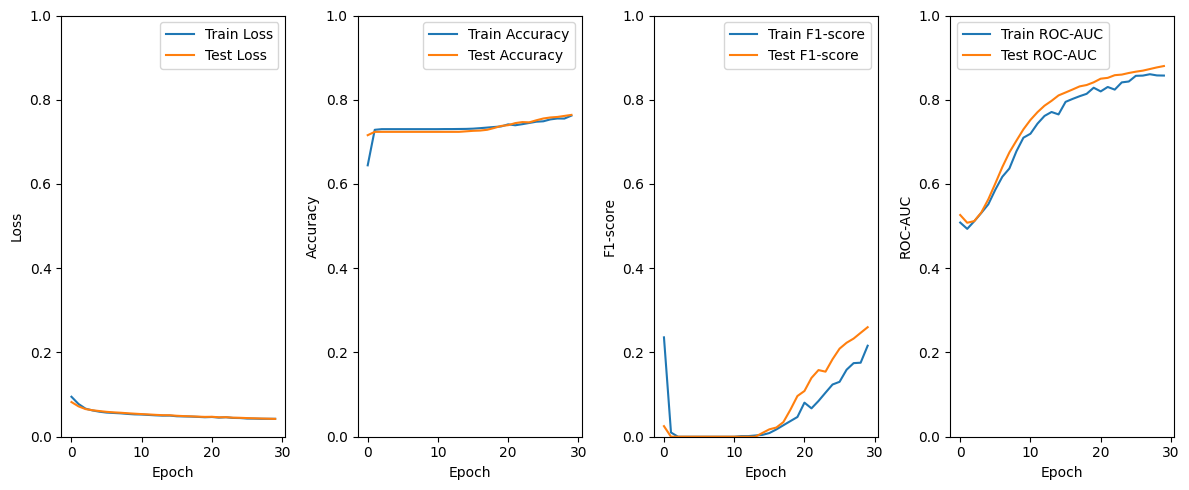

In [14]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_model_ft_resnet50_mcmlc.png',
    title='Training Evolution - Fine Tuned ResNet50 Multi-Class Multi-Labeling',
    zoomed=False
)


## 7. Model evaluation

In [15]:
model = resnet50(weights="IMAGENET1K_V2")
model.fc = nn.Linear(model.fc.in_features, NUMBER_OF_LABELS) 
model = model.to(device) 
model.load_state_dict(torch.load('../Models/model_ft_resnet50_mcmlc.pth', weights_only=True))

<All keys matched successfully>

In [16]:
val_loss, val_accuracy, val_f1, val_roc_auc = validate(model, val_loader, criterion, device=device, num_labels=NUMBER_OF_LABELS)

In [17]:
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation F1-score: {val_f1:.4f} | Validation ROC-AUC: {val_roc_auc:.4f}")

Validation Loss: 0.0383 | Validation Accuracy: 0.7700 | Validation F1-score: 0.2807 | Validation ROC-AUC: 0.8898
